In [2]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os

In [87]:
NUMBER_OF_RUNS_IN_EXPERIMENT = 20

In [3]:
percolator_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/percolator_df.pkl')

In [4]:
percolator_df.columns

Index(['file_idx', 'scan', 'charge_x', 'spectrum precursor m/z',
       'spectrum neutral mass', 'peptide mass', 'percolator score',
       'percolator q-value', 'percolator PEP', 'total matches/spectrum',
       'sequence', 'protein id', 'flanking aa', 'feature_id', 'charge_y',
       'rt_apex', 'scan_apex', 'intensity', 'precursor_id',
       'monoisotopic_mass', 'predicted_mass_error',
       'recalibrated_monoisotopic_mass', 'recalibrated_monoisotopic_mz',
       'percolator_idx', 'batch', 'human'],
      dtype='object')

In [8]:
# find the experiment-average for each sequence-charge
experiment_sequences_l = []
for group_name,group_df in percolator_df.groupby(['sequence','charge_x'], as_index=False):
    sequence = group_name[0]
    charge = group_name[1]
    theoretical_mz = group_df.iloc[0]['spectrum precursor m/z']
    experiment_average_scan = group_df.scan_apex.mean()
    experiment_average_rt = group_df.rt_apex.mean()
    experiment_sequences_l.append((sequence, charge, theoretical_mz, experiment_average_scan, experiment_average_rt))

In [10]:
experiment_sequences_df = pd.DataFrame(experiment_sequences_l, columns=['sequence','charge','theoretical_mz', 'experiment_average_scan', 'experiment_average_rt'])

In [11]:
experiment_sequences_df.head()

,sequence,charge,theoretical_mz,experiment_average_scan,experiment_average_rt
0,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1184.1049,73.528889,604.371111
1,AAAAAAAAAPAAAATAPTTAATTAATAAQ,3,789.7394,336.016667,609.890000
2,AAAAAAAAVPSAGPAGPAPTSAAGR,2,1016.0286,159.998000,489.613333
3,AAAAALSQQQSLQER,2,785.9075,496.325000,375.042500
4,AAAAATVVPPMVGGPPFVGPVGFGPGDR,3,864.1171,706.957407,1039.716667


In [9]:
run_sequences_l = []
for group_name,group_df in percolator_df.groupby(['file_idx','sequence','charge_x'], as_index=False):
    file_idx = group_name[0]
    sequence = group_name[1]
    charge = group_name[2]
    run_average_mz = group_df.recalibrated_monoisotopic_mz.mean()
    run_average_scan = group_df.scan_apex.mean()
    run_average_rt = group_df.rt_apex.mean()
    run_sequences_l.append((file_idx,sequence,charge,run_average_mz,run_average_scan,run_average_rt))

In [12]:
run_sequences_df = pd.DataFrame(run_sequences_l, columns=['file_idx','sequence','charge','run_average_mz','run_average_scan','run_average_rt'])

In [13]:
run_sequences_df.head()

,file_idx,sequence,charge,run_average_mz,run_average_scan,run_average_rt
0,0,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1184.608396,74.015000,601.575
1,0,AAAAAAAAVPSAGPAGPAPTSAAGR,2,1016.532319,156.406667,486.690
2,0,AAAAAWEEPSSGNGTAR,2,823.382064,535.310000,367.240
3,0,AAAAPVTGPLADDPIQETITFDDFAK,3,892.112987,468.100000,997.180
4,0,AAAEDVNVTFEDQQK,2,832.891998,485.630000,471.790


In [14]:
merged_df = pd.merge(run_sequences_df, experiment_sequences_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])

In [15]:
merged_df.head()

,file_idx,sequence,charge,run_average_mz,run_average_scan,run_average_rt,theoretical_mz,experiment_average_scan,experiment_average_rt
0,0,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1184.608396,74.015000,601.575,1184.1049,73.528889,604.371111
1,0,AAAAAAAAVPSAGPAGPAPTSAAGR,2,1016.532319,156.406667,486.690,1016.0286,159.998000,489.613333
2,0,AAAAAWEEPSSGNGTAR,2,823.382064,535.310000,367.240,822.8783,532.994286,371.006190
3,0,AAAAPVTGPLADDPIQETITFDDFAK,3,892.112987,468.100000,997.180,891.7775,465.181500,997.738000
4,0,AAAEDVNVTFEDQQK,2,832.891998,485.630000,471.790,832.3878,486.112727,474.475455


Generate the training sets for each run

In [90]:
mapping_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/percolator_mapping_df.pkl')

In [92]:
TRAINING_SET_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/training-sets'

In [94]:
for file_idx in range(NUMBER_OF_RUNS_IN_EXPERIMENT):
    X_df = merged_df[merged_df.file_idx == file_idx][['theoretical_mz','experiment_average_scan','experiment_average_rt']]
    y_df = merged_df[merged_df.file_idx == file_idx][['run_average_mz','run_average_scan','run_average_rt']]
    run_name = mapping_df[mapping_df.file_idx == file_idx].run_name.iloc[0]
    training_set_file_name_X = "{}/X_df-file-{}-{}.pkl".format(TRAINING_SET_DIR, file_idx, run_name)
    X_df.to_pickle(training_set_file_name_X)
    training_set_file_name_y = "{}/y_df-file-{}-{}.pkl".format(TRAINING_SET_DIR, file_idx, run_name)
    y_df.to_pickle(training_set_file_name_y)

Extract the training set for file_idx = 0

In [107]:
X_df = merged_df[merged_df.file_idx == 0][['theoretical_mz','experiment_average_scan','experiment_average_rt']]
y_df = merged_df[merged_df.file_idx == 0][['run_average_mz','run_average_scan','run_average_rt']]

In [108]:
X = X_df.values
y = y_df.values

In [109]:
from sklearn import preprocessing

In [110]:
min_max_scaler = preprocessing.MinMaxScaler()

In [111]:
X_scaled = min_max_scaler.fit_transform(X)

In [112]:
from sklearn.model_selection import train_test_split

In [113]:
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X_scaled, y, test_size=0.3)

In [114]:
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5)

In [115]:
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(9697, 3) (2078, 3) (2078, 3) (9697, 3) (2078, 3) (2078, 3)


In [139]:
import keras
from keras.models import Model
from keras.layers import Input, Dense

In [180]:
keras.backend.clear_session()

In [181]:
inputs = Input(shape=(3,), dtype='float32', name='main_input')

In [182]:
x = Dense(32, activation='relu')(inputs)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(3, activation='sigmoid')(x)

In [183]:
model = Model(inputs=inputs, outputs=predictions)

In [184]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [185]:
hist = model.fit(X_train, y_train,
          batch_size=8, epochs=200,
          validation_data=(X_val, y_val))

Train on 9697 samples, validate on 2078 samples
Epoch 1/200
9697/9697 [==============================] - 2s 170us/step - loss: 504894.0266 - acc: 0.1521 - val_loss: 501458.3028 - val_acc: 0.1631
Epoch 2/200
9697/9697 [==============================] - 2s 158us/step - loss: 504893.3897 - acc: 0.1702 - val_loss: 501458.3028 - val_acc: 0.2026
Epoch 3/200
9697/9697 [==============================] - 2s 156us/step - loss: 504893.3900 - acc: 0.2067 - val_loss: 501458.3028 - val_acc: 0.2310
Epoch 4/200
9697/9697 [==============================] - 2s 162us/step - loss: 504893.3907 - acc: 0.2422 - val_loss: 501458.3028 - val_acc: 0.2565
Epoch 5/200
9697/9697 [==============================] - 2s 159us/step - loss: 504893.3915 - acc: 0.2771 - val_loss: 501458.3028 - val_acc: 0.2897
Epoch 6/200
9697/9697 [==============================] - 2s 224us/step - loss: 504893.3912 - acc: 0.3019 - val_loss: 501458.3028 - val_acc: 0.3219
Epoch 7/200
9697/9697 [==============================] - 2s 228us/step

9697/9697 [==============================] - 2s 175us/step - loss: 504893.3911 - acc: 0.5440 - val_loss: 501458.3028 - val_acc: 0.5390
Epoch 57/200
9697/9697 [==============================] - 2s 171us/step - loss: 504893.3906 - acc: 0.5446 - val_loss: 501458.3028 - val_acc: 0.5428
Epoch 58/200
9697/9697 [==============================] - 2s 175us/step - loss: 504893.3901 - acc: 0.5468 - val_loss: 501458.3028 - val_acc: 0.5428
Epoch 59/200
9697/9697 [==============================] - 2s 193us/step - loss: 504893.3908 - acc: 0.5460 - val_loss: 501458.3028 - val_acc: 0.5462
Epoch 60/200
9697/9697 [==============================] - 2s 183us/step - loss: 504893.3902 - acc: 0.5454 - val_loss: 501458.3028 - val_acc: 0.5409
Epoch 61/200
9697/9697 [==============================] - 2s 172us/step - loss: 504893.3902 - acc: 0.5475 - val_loss: 501458.3028 - val_acc: 0.5448
Epoch 62/200
9697/9697 [==============================] - 2s 169us/step - loss: 504893.3901 - acc: 0.5469 - val_loss: 501458.

9697/9697 [==============================] - 1s 141us/step - loss: 504893.3909 - acc: 0.5602 - val_loss: 501458.3028 - val_acc: 0.5621
Epoch 112/200
9697/9697 [==============================] - 1s 148us/step - loss: 504893.3911 - acc: 0.5601 - val_loss: 501458.3028 - val_acc: 0.5621
Epoch 113/200
9697/9697 [==============================] - 1s 142us/step - loss: 504893.3916 - acc: 0.5604 - val_loss: 501458.3028 - val_acc: 0.5626
Epoch 114/200
9697/9697 [==============================] - 2s 185us/step - loss: 504893.3896 - acc: 0.5601 - val_loss: 501458.3028 - val_acc: 0.5621
Epoch 115/200
9697/9697 [==============================] - 3s 258us/step - loss: 504893.3900 - acc: 0.5601 - val_loss: 501458.3028 - val_acc: 0.5616
Epoch 116/200
9697/9697 [==============================] - 2s 185us/step - loss: 504893.3910 - acc: 0.5614 - val_loss: 501458.3028 - val_acc: 0.5616
Epoch 117/200
9697/9697 [==============================] - 2s 156us/step - loss: 504893.3906 - acc: 0.5625 - val_loss: 5

9697/9697 [==============================] - 2s 156us/step - loss: 504893.3906 - acc: 0.5654 - val_loss: 501458.3028 - val_acc: 0.5659
Epoch 167/200
9697/9697 [==============================] - 1s 154us/step - loss: 504893.3901 - acc: 0.5663 - val_loss: 501458.3028 - val_acc: 0.5674
Epoch 168/200
9697/9697 [==============================] - 2s 156us/step - loss: 504893.3911 - acc: 0.5653 - val_loss: 501458.3028 - val_acc: 0.5659
Epoch 169/200
9697/9697 [==============================] - 1s 154us/step - loss: 504893.3909 - acc: 0.5647 - val_loss: 501458.3028 - val_acc: 0.5650
Epoch 170/200
9697/9697 [==============================] - 1s 154us/step - loss: 504893.3908 - acc: 0.5642 - val_loss: 501458.3028 - val_acc: 0.5674
Epoch 171/200
9697/9697 [==============================] - 1s 152us/step - loss: 504893.3905 - acc: 0.5651 - val_loss: 501458.3028 - val_acc: 0.5650
Epoch 172/200
9697/9697 [==============================] - 2s 155us/step - loss: 504893.3914 - acc: 0.5647 - val_loss: 5

In [75]:
import matplotlib.pyplot as plt

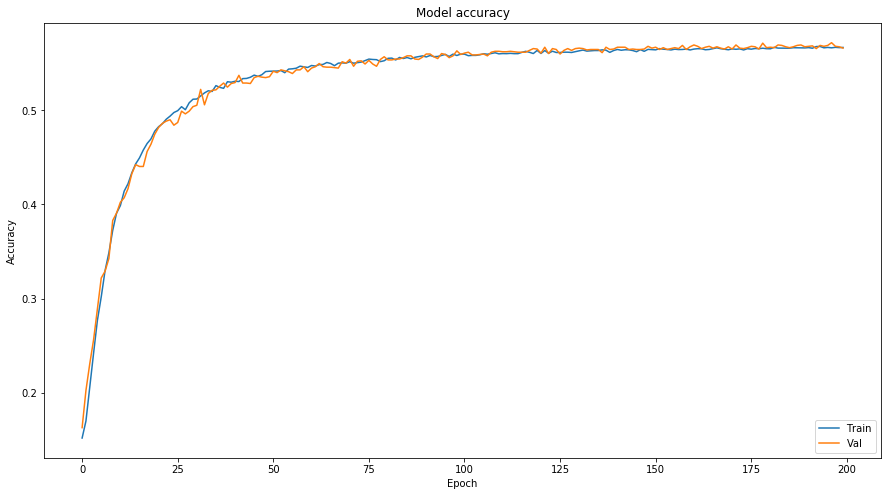

In [186]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [187]:
model.evaluate(X_test, y_test)[1]

2078/2078 [==============================] - 0s 27us/step


0.5726660249666943

In [188]:
model.predict(X_train)

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       ...,
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=float32)

In [189]:
X_train

array([[0.39027931, 0.50293918, 0.88479407],
       [0.51491844, 0.4500216 , 0.63824784],
       [0.15817708, 0.68468095, 0.90609317],
       ...,
       [0.49995939, 0.19275479, 0.66202219],
       [0.32906679, 0.44566312, 0.42464149],
       [0.30942315, 0.71406285, 0.84682435]])

In [190]:
model.predict_on_batch(X_test)

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       ...,
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=float32)